In [10]:
# Importing libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from keras.datasets import cifar10
from keras.utils import to_categorical
from keras.models import Sequential
from keras import Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, GlobalAveragePooling2D, Dropout, RandomFlip, RandomRotation, BatchNormalization, Activation
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.backend import clear_session
from keras.regularizers import l2
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy

from keras import layers

In [11]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [12]:
# Create a Dataset object from the training data
custom_class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))

# Set the class names attribute of the Dataset object
train_dataset.class_names = custom_class_names

In [13]:
### PLOTTING 10 SAMPLES FROM EACH CLASS ###
""" # Create a 10x10 subplot grid
fig, axs = plt.subplots(10, 10, figsize=(6, 6))

# Iterate over each class
for i, c in enumerate(np.unique(y_train)):
    # Select 10 random samples from this class
    idx = np.random.choice(np.where(y_train == c)[0], 10, replace=False)
    
    # Iterate over the 10 random samples
    for j, idx_j in enumerate(idx):
        # Get the corresponding image
        img = x_train[idx_j]
        
        # Display the image in the subplot
        axs[j, i].imshow(img)
        axs[j, i].set_xticks([])
        axs[j, i].set_yticks([])

# Layout so plots do not overlap
fig.tight_layout()
plt.show() """

' # Create a 10x10 subplot grid\nfig, axs = plt.subplots(10, 10, figsize=(6, 6))\n\n# Iterate over each class\nfor i, c in enumerate(np.unique(y_train)):\n    # Select 10 random samples from this class\n    idx = np.random.choice(np.where(y_train == c)[0], 10, replace=False)\n    \n    # Iterate over the 10 random samples\n    for j, idx_j in enumerate(idx):\n        # Get the corresponding image\n        img = x_train[idx_j]\n        \n        # Display the image in the subplot\n        axs[j, i].imshow(img)\n        axs[j, i].set_xticks([])\n        axs[j, i].set_yticks([])\n\n# Layout so plots do not overlap\nfig.tight_layout()\nplt.show() '

In [14]:
# Normalizing the images
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [15]:
# Convert the labels from numerical to categorical (one-hot encoded)
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [16]:
""" # Data Augmentation
data_augmentation = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2)])

# Create a tf.data.Dataset
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

# Visualize augmented images
for images, _ in train_dataset.take(1):
    plt.figure(figsize=(4, 4))
    first_image = images[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0])
        plt.axis('off')
    plt.show()
 """

" # Data Augmentation\ndata_augmentation = Sequential([\n    RandomFlip('horizontal'),\n    RandomRotation(0.2)])\n\n# Create a tf.data.Dataset\ntrain_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)\n\n# Visualize augmented images\nfor images, _ in train_dataset.take(1):\n    plt.figure(figsize=(4, 4))\n    first_image = images[0]\n    for i in range(9):\n        ax = plt.subplot(3, 3, i + 1)\n        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))\n        plt.imshow(augmented_image[0])\n        plt.axis('off')\n    plt.show()\n "

In [17]:
# Learning Rate Scheduler to adjust the learning rate during training
lr_scheduler = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=3, verbose=1)

In [18]:
### SEQUENTIAL MODEL ###
# TODO: Learning rate Scheduler
# TODO: Kernel Regularizer
clear_session()

# Defining the model
model_seq = Sequential()
model_seq.add(Input(shape=(32, 32, 3)))

# Data augmentation layers
model_seq.add(layers.RandomTranslation(height_factor=0.05, width_factor=0.05))
model_seq.add(layers.RandomFlip("horizontal"))

# 1st Convolutional Block
model_seq.add(Conv2D(64, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(Conv2D(64, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(MaxPooling2D((2, 2)))
model_seq.add(Dropout(0.1))

# 2nd Convolutional Block
model_seq.add(Conv2D(128, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(Conv2D(128, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(MaxPooling2D((2, 2)))
model_seq.add(Dropout(0.2))

# 3rd Convolutional Block
model_seq.add(Conv2D(256, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(Conv2D(256, (3, 3), padding='same'))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(MaxPooling2D((2, 2)))
model_seq.add(Dropout(0.5))

# Dense Layers
model_seq.add(Flatten())
model_seq.add(Dense(128, kernel_regularizer=l2(0.005)))
model_seq.add(BatchNormalization())
model_seq.add(Activation("relu"))
model_seq.add(Dropout(0.4))

# Output Layer
model_seq.add(Dense(10, activation='softmax'))

#model_seq.summary()

# Define Early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', restore_best_weights=True)

do_train_seq = True
if do_train_seq:
    # Compiling the model # TODO: Try different accuracy metrics?
    model_seq.compile(optimizer=Adam(), loss=CategoricalCrossentropy(label_smoothing=0.1), metrics=['accuracy'])

    # Training the model
    history = model_seq.fit(x_train, y_train,
        epochs=100, #50
        batch_size=128, #512
        validation_split=0.2,
        #validation_steps=int(0.2 * x_test.shape[0] / 512), # Fixed because we're generating val data automatically with validation_split
        callbacks=[early_stopping, lr_scheduler]
        )

Epoch 1/100
313/313 [==============================] - 9s 18ms/step - loss: 2.4608 - accuracy: 0.4166 - val_loss: 3.0889 - val_accuracy: 0.1301 - lr: 0.0010
Epoch 2/100
313/313 [==============================] - 5s 16ms/step - loss: 1.6945 - accuracy: 0.5806 - val_loss: 1.6381 - val_accuracy: 0.6127 - lr: 0.0010
Epoch 3/100
313/313 [==============================] - 5s 16ms/step - loss: 1.5077 - accuracy: 0.6528 - val_loss: 1.4562 - val_accuracy: 0.6640 - lr: 0.0010
Epoch 4/100
313/313 [==============================] - 5s 16ms/step - loss: 1.4314 - accuracy: 0.6878 - val_loss: 1.3065 - val_accuracy: 0.7415 - lr: 0.0010
Epoch 5/100
313/313 [==============================] - 5s 16ms/step - loss: 1.3737 - accuracy: 0.7145 - val_loss: 1.3538 - val_accuracy: 0.7173 - lr: 0.0010
Epoch 6/100
313/313 [==============================] - 5s 16ms/step - loss: 1.3302 - accuracy: 0.7346 - val_loss: 1.2814 - val_accuracy: 0.7469 - lr: 0.0010
Epoch 7/100
313/313 [==============================] - 5s 

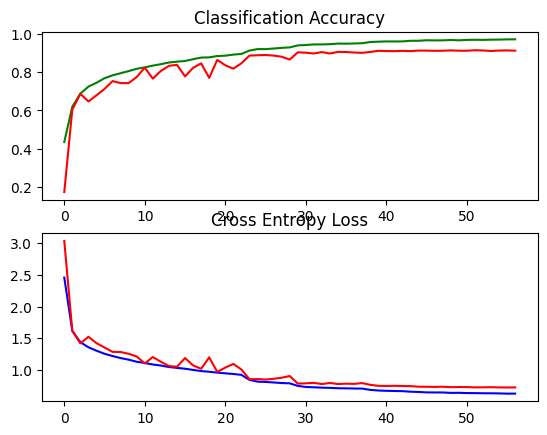

313/313 [==============================] - 1s 3ms/step - loss: 0.7338 - accuracy: 0.9133
Test accuracy: 0.9133
Test loss: 0.7338


In [19]:
# Plot Accuracy
plt.subplot(211)
plt.title('Classification Accuracy')
plt.plot(history.history['accuracy'], color='green', label='train')
plt.plot(history.history['val_accuracy'], color='red', label='val')

# Plot Loss
plt.subplot(212)
plt.title('Cross Entropy Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='val')
plt.show()

# Printing the loss and accuracy
model = model_seq

test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc.__round__(4))
print('Test loss:', test_loss.__round__(4))

# Adam, DropOuts: Acc = 0.8317 Loss = 0.5056
# Adam, NoDropOuts: Acc = 0.7353 Loss = 0.7353
# SGD, NoDropOuts: Acc = 0.5973 Loss = 1.1429

313/313 [==============================] - 1s 1ms/step


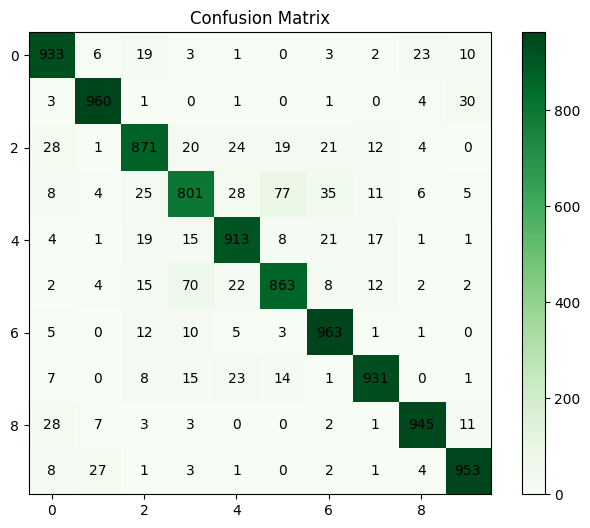

In [20]:
# TODO: Class Names...?

# Making predictions
predictions = model.predict(x_test)

# Creating a Confussion matrix
cm = confusion_matrix(
    np.argmax(y_test, axis=1),
    np.argmax(predictions, axis=1))

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap='Greens')
plt.title('Confusion Matrix')
plt.colorbar()

# Use the custom class names as tick labels
plt.xticks(range(len(custom_class_names)), custom_class_names, rotation=45)
plt.yticks(range(len(custom_class_names)), custom_class_names)

# Add numbers to the confusion matrix
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='black')

plt.show()